## 1. Setup & Data Loading

In [101]:
# Core libraries
import pandas as pd
import numpy as np
import json
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Statistics
from scipy import stats
from scipy.stats import f_oneway
from sklearn.metrics import adjusted_rand_score, cohen_kappa_score

# Configuration
RANDOM_STATE = 67
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries loaded successfully")

Libraries loaded successfully


In [102]:
# Load data
DATA_PATH = Path('data/AIRS_clean.csv')
df = pd.read_csv(DATA_PATH)
print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

# Define construct items
AIRS16_CONSTRUCTS = ['PE', 'EE', 'SI', 'FC', 'HM', 'PV', 'HB', 'TR']
OUTCOME = 'BI'

# Compute construct scores (2 items each for AIRS-16, 4 items for BI)
for c in AIRS16_CONSTRUCTS:
    df[c] = df[[f'{c}1', f'{c}2']].mean(axis=1)
df['BI'] = df[['BI1', 'BI2', 'BI3', 'BI4']].mean(axis=1)

print(f"\nConstruct scores computed:")
print(f"  AIRS-16: {AIRS16_CONSTRUCTS}")
print(f"  Outcome: {OUTCOME}")

Dataset loaded: 523 rows × 41 columns

Construct scores computed:
  AIRS-16: ['PE', 'EE', 'SI', 'FC', 'HM', 'PV', 'HB', 'TR']
  Outcome: BI


---
## 2. Exploratory Analysis

### 2.1 Descriptive Statistics

In [103]:
# Descriptive statistics for all constructs
all_constructs = AIRS16_CONSTRUCTS + [OUTCOME]
desc_stats = df[all_constructs].describe().T
desc_stats['skew'] = df[all_constructs].skew()
desc_stats['kurtosis'] = df[all_constructs].kurtosis()

print("Table 11.0: Descriptive Statistics for AIRS-16 Constructs and BI")
print("=" * 70)
display(desc_stats.round(3))

Table 11.0: Descriptive Statistics for AIRS-16 Constructs and BI


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
PE,523.0,3.467,1.079,1.0,3.0,3.50,4.00,5.0,-0.670,-0.126
EE,523.0,3.644,0.977,1.0,3.0,4.00,4.25,5.0,-0.716,0.155
SI,523.0,3.174,1.042,1.0,2.5,3.00,4.00,5.0,-0.134,-0.564
FC,523.0,3.349,1.004,1.0,2.5,3.50,4.00,5.0,-0.388,-0.401
HM,523.0,3.317,1.139,1.0,2.5,3.50,4.00,5.0,-0.558,-0.487
PV,523.0,3.428,1.113,1.0,3.0,3.50,4.00,5.0,-0.625,-0.350
HB,523.0,3.021,1.253,1.0,2.0,3.00,4.00,5.0,-0.149,-1.039
TR,523.0,3.222,1.147,1.0,2.5,3.50,4.00,5.0,-0.433,-0.641
BI,523.0,3.185,1.111,1.0,2.5,3.25,4.00,5.0,-0.435,-0.676


### 2.2 Correlation Analysis

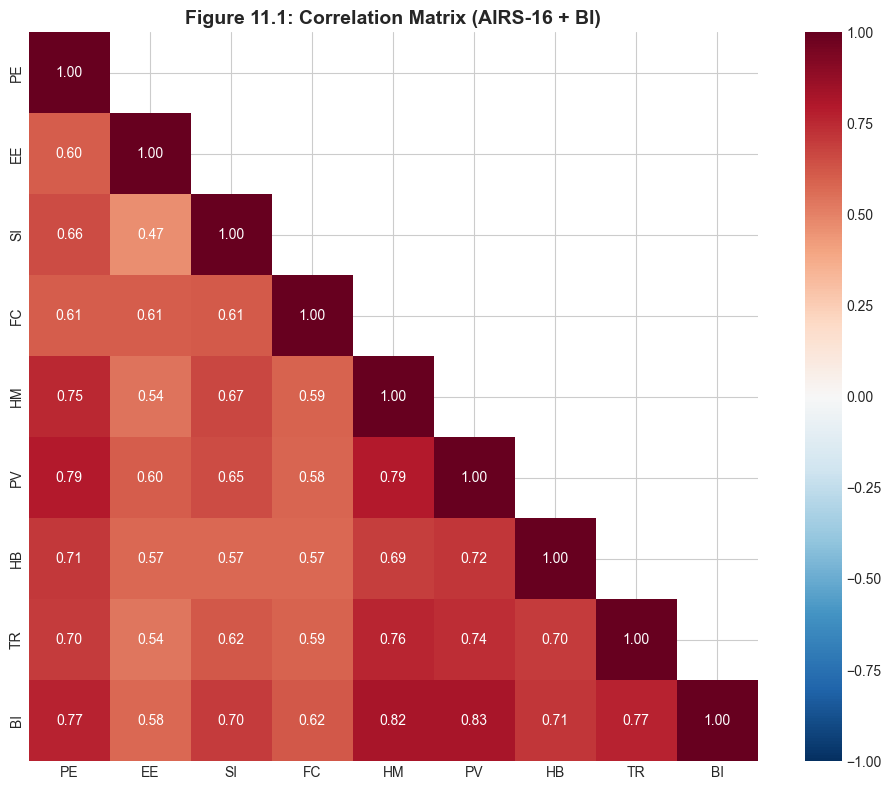


Correlations with BI (sorted by strength):
  PV: r = 0.826
  HM: r = 0.821
  TR: r = 0.771
  PE: r = 0.768
  HB: r = 0.712
  SI: r = 0.699
  FC: r = 0.625
  EE: r = 0.578


In [104]:
# Correlation matrix
corr_matrix = df[all_constructs].corr()

# Figure 11.1: Correlation Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True, ax=ax)
ax.set_title('Figure 11.1: Correlation Matrix (AIRS-16 + BI)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/11_01_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCorrelations with BI (sorted by strength):")
bi_corrs = corr_matrix['BI'].drop('BI').sort_values(ascending=False)
for construct, r in bi_corrs.items():
    print(f"  {construct}: r = {r:.3f}")

Correlation: AI Readiness Index (ARI) vs Behavioral Intention (BI)
ARI = Sum of 8 construct means (range: 8-40)

Pearson r = 0.876
R² = 0.768 (76.8% variance explained)

Interpretation: Strong positive correlation


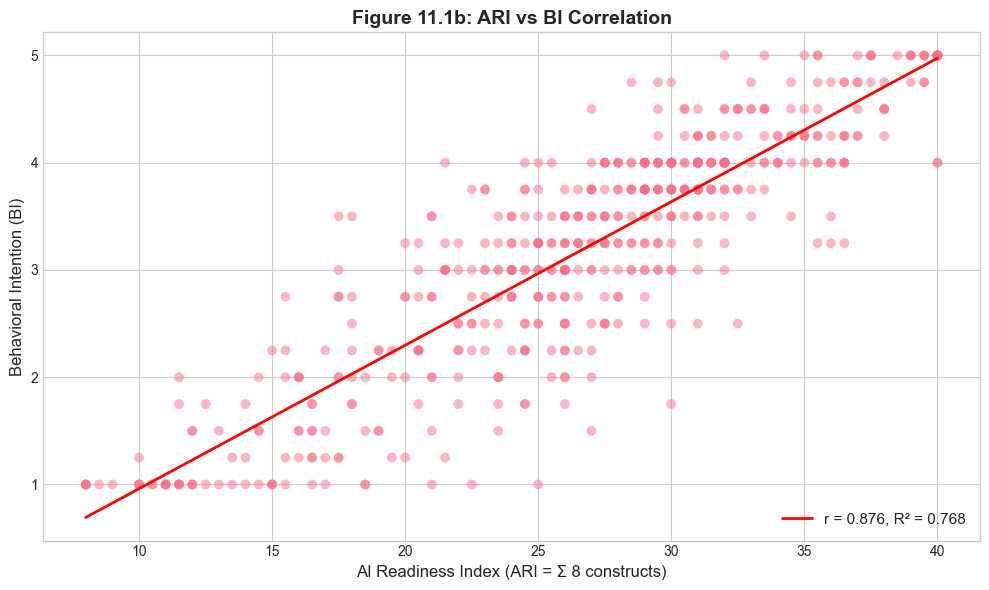

In [105]:
# Correlation between BI and AI Readiness Index (sum of 8 constructs)
df['ARI'] = df[AIRS16_CONSTRUCTS].sum(axis=1)

# Calculate correlation
r_ari_bi = df['ARI'].corr(df['BI'])
r_squared = r_ari_bi ** 2

print("Correlation: AI Readiness Index (ARI) vs Behavioral Intention (BI)")
print("=" * 60)
print(f"ARI = Sum of {len(AIRS16_CONSTRUCTS)} construct means (range: 8-40)")
print(f"\nPearson r = {r_ari_bi:.3f}")
print(f"R² = {r_squared:.3f} ({r_squared*100:.1f}% variance explained)")
print(f"\nInterpretation: {'Strong' if abs(r_ari_bi) >= 0.7 else 'Moderate' if abs(r_ari_bi) >= 0.4 else 'Weak'} positive correlation")

# Figure: Scatter plot ARI vs BI
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['ARI'], df['BI'], alpha=0.5, edgecolors='none', s=50)

# Add regression line
z = np.polyfit(df['ARI'], df['BI'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['ARI'].min(), df['ARI'].max(), 100)
ax.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'r = {r_ari_bi:.3f}, R² = {r_squared:.3f}')

ax.set_xlabel('AI Readiness Index (ARI = Σ 8 constructs)', fontsize=12)
ax.set_ylabel('Behavioral Intention (BI)', fontsize=12)
ax.set_title('Figure 11.1b: ARI vs BI Correlation', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)

plt.tight_layout()
plt.savefig('plots/11_01b_ari_bi_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.3 BI Predictor Identification

In [106]:
# Identify strongest BI predictors
print("Key Findings - BI Predictors:")
print("=" * 50)

strong_predictors = bi_corrs[bi_corrs.abs() >= 0.4].index.tolist()
moderate_predictors = bi_corrs[(bi_corrs.abs() >= 0.3) & (bi_corrs.abs() < 0.4)].index.tolist()
weak_predictors = bi_corrs[bi_corrs.abs() < 0.3].index.tolist()

print(f"Strong predictors (|r| >= 0.4): {strong_predictors}")
print(f"Moderate predictors (0.3 <= |r| < 0.4): {moderate_predictors}")
print(f"Weak predictors (|r| < 0.3): {weak_predictors}")

Key Findings - BI Predictors:
Strong predictors (|r| >= 0.4): ['PV', 'HM', 'TR', 'PE', 'HB', 'SI', 'FC', 'EE']
Moderate predictors (0.3 <= |r| < 0.4): []
Weak predictors (|r| < 0.3): []


---
## 3. Cluster Analysis

### 3.1 Optimal k Determination

In [107]:
# Prepare data for clustering (AIRS-16 only, not BI)
X = df[AIRS16_CONSTRUCTS].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Clustering input: {X_scaled.shape[0]} samples × {X_scaled.shape[1]} features")
print(f"Features: {AIRS16_CONSTRUCTS}")

Clustering input: 523 samples × 8 features
Features: ['PE', 'EE', 'SI', 'FC', 'HM', 'PV', 'HB', 'TR']


In [108]:
# Test k = 2 to 8
K_RANGE = range(2, 9)
inertias = []
silhouettes = []

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Table 11.2: Cluster Determination Metrics
cluster_metrics = pd.DataFrame({
    'k': list(K_RANGE),
    'Inertia': inertias,
    'Silhouette': silhouettes
})
print("Table 11.2: Cluster Determination Metrics")
print("=" * 50)
display(cluster_metrics.round(3))

Table 11.2: Cluster Determination Metrics


,k,Inertia,Silhouette
0,2,2317.731,0.373
1,3,1759.297,0.271
2,4,1535.370,0.226
3,5,1438.616,0.191
4,6,1354.471,0.194
5,7,1273.333,0.191
6,8,1212.045,0.189


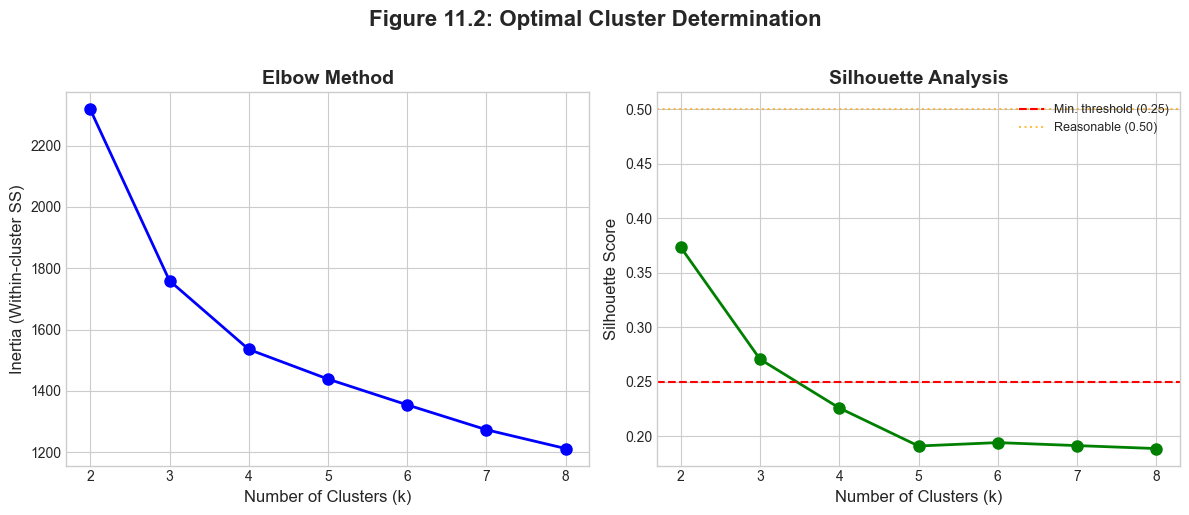


Optimal k based on silhouette: 2


In [109]:
# Figure 11.2: Elbow Plot + Silhouette Scores
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Elbow plot
axes[0].plot(list(K_RANGE), inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster SS)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].set_xticks(list(K_RANGE))

# Silhouette plot
# Note: Silhouette interpretation (Kaufman & Rousseeuw, 1990):
# 0.71-1.00: Strong structure, 0.51-0.70: Reasonable, 0.26-0.50: Weak, <0.25: No structure
axes[1].plot(list(K_RANGE), silhouettes, 'go-', linewidth=2, markersize=8)
axes[1].axhline(y=0.25, color='r', linestyle='--', label='Min. threshold (0.25)')
axes[1].axhline(y=0.50, color='orange', linestyle=':', alpha=0.7, label='Reasonable (0.50)')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].set_xticks(list(K_RANGE))
axes[1].legend(loc='upper right', fontsize=9)

fig.suptitle('Figure 11.2: Optimal Cluster Determination', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plots/11_02_elbow_silhouette.png', dpi=150, bbox_inches='tight')
plt.show()


# Identify optimal k
optimal_k = cluster_metrics.loc[cluster_metrics['Silhouette'].idxmax(), 'k']
print(f"\nOptimal k based on silhouette: {int(optimal_k)}")

### 3.2 K-Means Clustering

In [110]:
# Final clustering with selected k
# NOTE: k=2 has highest silhouette (0.373), k=3 (0.271) exceeds threshold
# Using k=3 for balance of parsimony and interpretability
# INTERPRETATION (Kaufman & Rousseeuw, 1990): Silhouette 0.271 indicates "weak but acceptable"
# structure - clusters exist but with some overlap. This is typical for psychometric data.
SELECTED_K = 3  # Based on silhouette analysis (>0.25 minimum threshold)

kmeans_final = KMeans(n_clusters=SELECTED_K, random_state=RANDOM_STATE, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

final_silhouette = silhouette_score(X_scaled, df['Cluster'])
print(f"Final clustering: k = {SELECTED_K}")
print(f"Silhouette score: {final_silhouette:.3f}")
print(f"\nCluster sizes:")
print(df['Cluster'].value_counts().sort_index())

Final clustering: k = 3
Silhouette score: 0.271

Cluster sizes:
Cluster
0    246
1    115
2    162
Name: count, dtype: int64


### 3.3 Cluster Profiling

In [111]:
# Calculate cluster centroids (z-scores and raw)
cluster_means_raw = df.groupby('Cluster')[AIRS16_CONSTRUCTS].mean()

# Calculate z-scores using population parameters
pop_means = df[AIRS16_CONSTRUCTS].mean()
pop_stds = df[AIRS16_CONSTRUCTS].std()
cluster_means_z = (cluster_means_raw - pop_means) / pop_stds

print("Table 11.3a: Cluster Centroids (Raw Scores)")
print("=" * 70)
display(cluster_means_raw.round(3))

print("\nTable 11.3b: Cluster Centroids (Z-Scores)")
print("=" * 70)
display(cluster_means_z.round(3))

Table 11.3a: Cluster Centroids (Raw Scores)


,PE,EE,SI,FC,HM,PV,HB,TR
Cluster,,,,,,,,
0,3.543,3.636,3.026,3.244,3.323,3.522,2.998,3.215
1,2.004,2.626,2.087,2.326,1.822,1.861,1.430,1.739
2,4.392,4.380,4.170,4.235,4.370,4.398,4.185,4.284



Table 11.3b: Cluster Centroids (Z-Scores)


,PE,EE,SI,FC,HM,PV,HB,TR
Cluster,,,,,,,,
0,0.070,-0.008,-0.142,-0.105,0.005,0.084,-0.018,-0.006
1,-1.356,-1.043,-1.043,-1.019,-1.313,-1.408,-1.270,-1.293
2,0.857,0.753,0.955,0.882,0.924,0.871,0.929,0.926


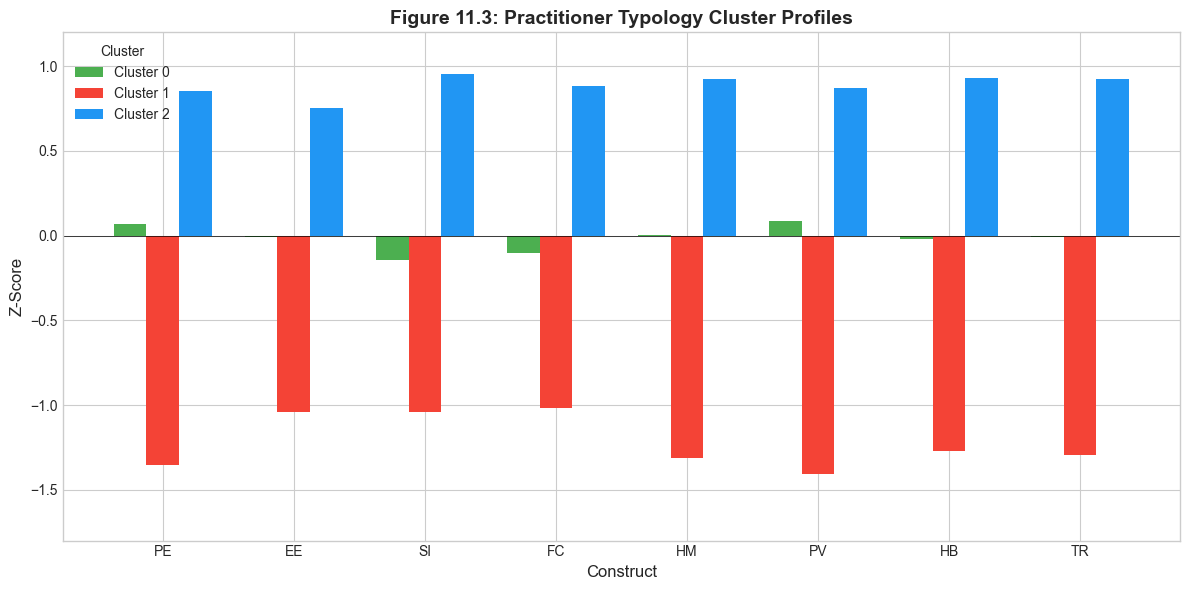

In [112]:
# Figure 11.3: Cluster Profiles
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(AIRS16_CONSTRUCTS))
width = 0.25
colors = ['#4CAF50', '#F44336', '#2196F3']  # Green, Red, Blue

for i in range(SELECTED_K):
    offset = (i - SELECTED_K/2 + 0.5) * width
    ax.bar(x + offset, cluster_means_z.iloc[i], width, label=f'Cluster {i}', color=colors[i])

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Construct', fontsize=12)
ax.set_ylabel('Z-Score', fontsize=12)
ax.set_title('Figure 11.3: Practitioner Typology Cluster Profiles', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(AIRS16_CONSTRUCTS)
ax.legend(title='Cluster')
ax.set_ylim(-1.8, 1.2)

plt.tight_layout()
plt.savefig('plots/11_03_cluster_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.4 Cluster Naming

In [113]:
# Name clusters based on profile characteristics
# Based on z-score patterns:
# Cluster 0: Average across all constructs (z ≈ 0) → "Moderate Users"
# Cluster 1: Low across all constructs (z ≈ -1.2) → "AI Skeptics"
# Cluster 2: High across all constructs (z ≈ +0.9) → "AI Enthusiasts"
CLUSTER_NAMES = {
    0: 'Moderate Users',    # Average scores, neutral position
    1: 'AI Skeptics',       # Low across all constructs
    2: 'AI Enthusiasts',    # High across all constructs
}

df['Typology'] = df['Cluster'].map(CLUSTER_NAMES)

print("Practitioner Typology Cluster Names:")
print("=" * 50)
for cluster_id, name in CLUSTER_NAMES.items():
    n = (df['Cluster'] == cluster_id).sum()
    pct = n / len(df) * 100
    print(f"  Cluster {cluster_id} → {name}: n={n} ({pct:.1f}%)")

Practitioner Typology Cluster Names:
  Cluster 0 → Moderate Users: n=246 (47.0%)
  Cluster 1 → AI Skeptics: n=115 (22.0%)
  Cluster 2 → AI Enthusiasts: n=162 (31.0%)


---
## 4. Predictive Validation

### 4.1 BI by Cluster (ANOVA)

In [114]:
# BI means by cluster
bi_by_cluster = df.groupby('Cluster')['BI'].agg(['mean', 'std', 'count'])
bi_by_cluster.columns = ['Mean BI', 'SD', 'n']

print("Table 11.4: Behavioral Intention by Cluster")
print("=" * 50)
display(bi_by_cluster.round(3))

Table 11.4: Behavioral Intention by Cluster


,Mean BI,SD,n
Cluster,,,
0,3.188,0.686,246
1,1.711,0.718,115
2,4.225,0.532,162


In [115]:
# ANOVA: Do clusters differ on BI?
cluster_groups = [df[df['Cluster'] == i]['BI'].values for i in range(SELECTED_K)]
f_stat, p_value = f_oneway(*cluster_groups)

# Calculate eta-squared (effect size)
grand_mean = df['BI'].mean()
ss_between = sum(len(g) * (g.mean() - grand_mean)**2 for g in cluster_groups)
ss_total = sum((df['BI'] - grand_mean)**2)
eta_squared = ss_between / ss_total

print("\nANOVA Results: Clusters → BI")
print("=" * 50)
print(f"F({SELECTED_K-1}, {len(df)-SELECTED_K}) = {f_stat:.2f}, p < .001" if p_value < .001 else f"F = {f_stat:.2f}, p = {p_value:.4f}")
print(f"η² = {eta_squared:.3f}")

# Interpret effect size (Cohen, 1988: η² thresholds: 0.01=small, 0.06=medium, 0.14=large)
if eta_squared >= 0.14:
    effect_interp = "large"
elif eta_squared >= 0.06:
    effect_interp = "medium"
else:
    effect_interp = "small"
print(f"Effect size interpretation: {effect_interp} (Cohen, 1988: η² ≥ 0.14 = large)")


ANOVA Results: Clusters → BI
F(2, 520) = 503.47, p < .001
η² = 0.659
Effect size interpretation: large (Cohen, 1988: η² ≥ 0.14 = large)


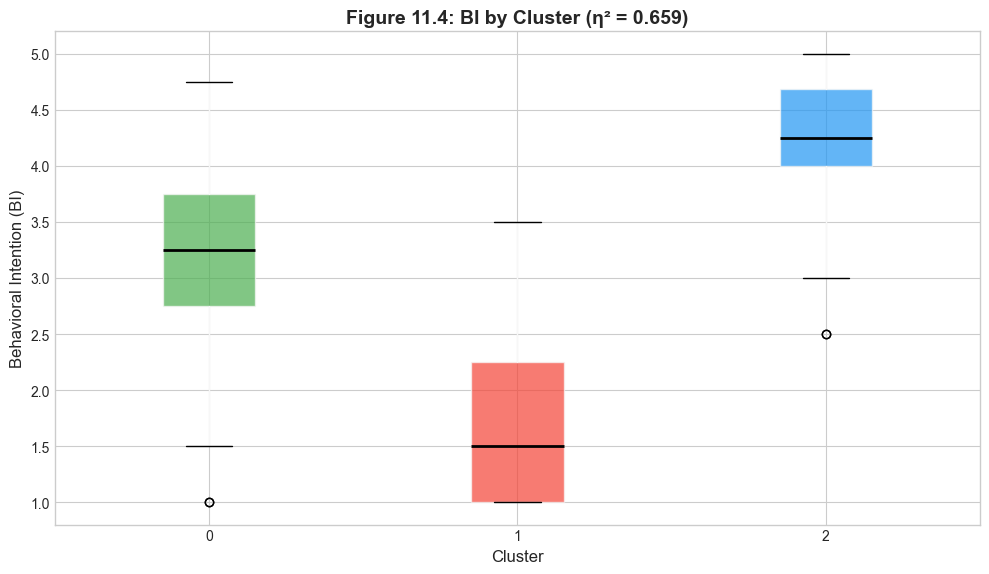

In [116]:
# Figure 11.4: BI Distribution by Cluster
fig, ax = plt.subplots(figsize=(10, 6))

# Use consistent colors matching the cluster profiles chart
colors = ['#4CAF50', '#F44336', '#2196F3']  # Green (Moderate), Red (Skeptics), Blue (Enthusiasts)
bp = df.boxplot(column='BI', by='Cluster', ax=ax, patch_artist=True, return_type='dict')

# Apply colors to boxplot
for i, (box, median) in enumerate(zip(bp['BI']['boxes'], bp['BI']['medians'])):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)
    median.set_color('black')
    median.set_linewidth(2)

ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Behavioral Intention (BI)', fontsize=12)
ax.set_title(f'Figure 11.4: BI by Cluster (η² = {eta_squared:.3f})', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.savefig('plots/11_04_bi_by_cluster.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.2 Regression Analysis

In [117]:
# Multiple regression: AIRS-16 → BI
X_reg = df[AIRS16_CONSTRUCTS]
y_reg = df['BI']

# Fit model
reg_model = LinearRegression()
reg_model.fit(X_reg, y_reg)

# R² and cross-validated R²
r2 = reg_model.score(X_reg, y_reg)
cv_scores = cross_val_score(reg_model, X_reg, y_reg, cv=5, scoring='r2')

print("Regression: AIRS-16 → BI")
print("=" * 50)
print(f"R² = {r2:.3f}")
print(f"Cross-validated R² = {cv_scores.mean():.3f} (SD = {cv_scores.std():.3f})")

Regression: AIRS-16 → BI
R² = 0.794
Cross-validated R² = 0.771 (SD = 0.056)


In [118]:
# Table 11.5: Regression Coefficients
# Standardized coefficients (beta)
X_std = (X_reg - X_reg.mean()) / X_reg.std()
reg_std = LinearRegression()
reg_std.fit(X_std, y_reg)

coef_table = pd.DataFrame({
    'Construct': AIRS16_CONSTRUCTS,
    'B (unstd)': reg_model.coef_,
    'β (std)': reg_std.coef_
}).sort_values('β (std)', ascending=False, key=abs)

print("Table 11.5: Regression Coefficients (AIRS-16 → BI)")
print("=" * 50)
display(coef_table.round(3))

Table 11.5: Regression Coefficients (AIRS-16 → BI)


,Construct,B (unstd),β (std)
5,PV,0.283,0.316
4,HM,0.251,0.286
7,TR,0.147,0.169
2,SI,0.132,0.138
0,PE,0.086,0.093
6,HB,0.050,0.063
3,FC,0.059,0.060
1,EE,0.014,0.013


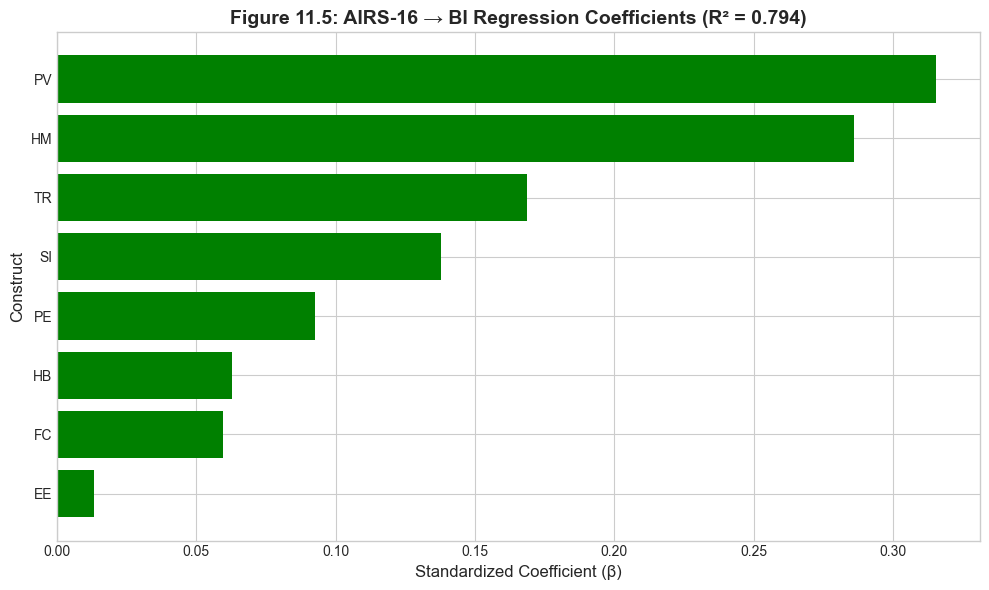

In [119]:
# Figure 11.5: Feature Importance
fig, ax = plt.subplots(figsize=(10, 6))

coef_sorted = coef_table.sort_values('β (std)')
colors = ['green' if x > 0 else 'red' for x in coef_sorted['β (std)']]
ax.barh(coef_sorted['Construct'], coef_sorted['β (std)'], color=colors)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Standardized Coefficient (β)', fontsize=12)
ax.set_ylabel('Construct', fontsize=12)
ax.set_title(f'Figure 11.5: AIRS-16 → BI Regression Coefficients (R² = {r2:.3f})', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/11_05_regression_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.3 Cluster-Based vs. Regression-Based Prediction

In [120]:
# Compare prediction methods
# Method 1: Cluster-based (use cluster mean BI)
# NOTE: Cluster-based R² is mathematically equivalent to ANOVA η² when using 
# cluster means as predictions. Both represent SS_between / SS_total.
cluster_bi_means = df.groupby('Cluster')['BI'].mean()
df['BI_pred_cluster'] = df['Cluster'].map(cluster_bi_means)
ss_res_cluster = sum((df['BI'] - df['BI_pred_cluster'])**2)
r2_cluster = 1 - ss_res_cluster / ss_total

# Method 2: Regression-based (continuous predictors = more variance explained)
# NOTE: Regression R² > Cluster R² because continuous AIRS-16 scores capture
# within-cluster variance that categorical cluster membership cannot.
df['BI_pred_reg'] = reg_model.predict(X_reg)
ss_res_reg = sum((df['BI'] - df['BI_pred_reg'])**2)
r2_reg = 1 - ss_res_reg / ss_total

print("Table 11.6: Prediction Method Comparison")
print("=" * 50)
print(f"Note: Cluster R² ({r2_cluster:.3f}) ≈ ANOVA η² ({eta_squared:.3f}) by design")
print(f"      Regression R² ({r2_reg:.3f}) > Cluster R² because continuous scores")
print(f"      capture within-cluster variance that cluster means cannot.\n")
comparison = pd.DataFrame({
    'Method': ['Cluster-based (= η²)', 'Regression-based'],
    'R²': [r2_cluster, r2_reg],
    'Simplicity': ['High', 'Medium'],
    'Interpretability': ['High', 'Medium']
})
display(comparison)

Table 11.6: Prediction Method Comparison
Note: Cluster R² (0.659) ≈ ANOVA η² (0.659) by design
      Regression R² (0.794) > Cluster R² because continuous scores
      capture within-cluster variance that cluster means cannot.



,Method,R²,Simplicity,Interpretability
0,Cluster-based (= η²),0.659452,High,High
1,Regression-based,0.794385,Medium,Medium


---
## 5. Diagnostic Tool Development

### 5.1 Population Parameters

In [121]:
# Store population parameters for practitioners
POP_PARAMS = {
    'means': pop_means.to_dict(),
    'stds': pop_stds.to_dict()
}

print("Population Parameters (for practitioner use):")
print("=" * 50)
params_table = pd.DataFrame({
    'Construct': AIRS16_CONSTRUCTS,
    'Mean': [POP_PARAMS['means'][c] for c in AIRS16_CONSTRUCTS],
    'SD': [POP_PARAMS['stds'][c] for c in AIRS16_CONSTRUCTS]
})
display(params_table.round(3))

Population Parameters (for practitioner use):


,Construct,Mean,SD
0,PE,3.467,1.079
1,EE,3.644,0.977
2,SI,3.174,1.042
3,FC,3.349,1.004
4,HM,3.317,1.139
5,PV,3.428,1.113
6,HB,3.021,1.253
7,TR,3.222,1.147


### 5.2 Centroid Storage

In [122]:
# Store centroids for classification
CENTROIDS = {}
for cluster_id in range(SELECTED_K):
    mask = df['Cluster'] == cluster_id
    CENTROIDS[CLUSTER_NAMES[cluster_id]] = {
        'cluster_id': cluster_id,
        'z_scores': cluster_means_z.loc[cluster_id].to_dict(),
        'raw_means': cluster_means_raw.loc[cluster_id].to_dict(),
        'expected_BI': df.loc[mask, 'BI'].mean(),
        'n': int(mask.sum()),
        'pct': mask.sum() / len(df) * 100
    }

print("Cluster Centroids Stored:")
for name, data in CENTROIDS.items():
    print(f"\n{name}:")
    print(f"  n = {data['n']} ({data['pct']:.1f}%)")
    print(f"  Expected BI = {data['expected_BI']:.2f}")

Cluster Centroids Stored:

Moderate Users:
  n = 246 (47.0%)
  Expected BI = 3.19

AI Skeptics:
  n = 115 (22.0%)
  Expected BI = 1.71

AI Enthusiasts:
  n = 162 (31.0%)
  Expected BI = 4.23


### 5.3 Classification Function

In [123]:
def classify_airs16_typology(pe, ee, si, fc, hm, pv, hb, tr, 
                             pop_params=POP_PARAMS, centroids=CENTROIDS):
    """
    Classify a respondent into AI readiness typology using AIRS-16 constructs.
    
    Parameters
    ----------
    pe, ee, si, fc, hm, pv, hb, tr : float
        Mean scores for each AIRS-16 construct (scale: 1-5)
    pop_params : dict
        Population means and SDs for standardization
    centroids : dict
        Cluster centroid data
    
    Returns
    -------
    dict
        typology: Assigned cluster name
        predicted_BI: Expected BI for this typology
        confidence: Classification confidence (inverse of distance)
        distances: Distances to all centroids
    """
    # Input scores
    scores = {'PE': pe, 'EE': ee, 'SI': si, 'FC': fc, 'HM': hm, 'PV': pv, 'HB': hb, 'TR': tr}
    
    # Standardize
    z_scores = {c: (scores[c] - pop_params['means'][c]) / pop_params['stds'][c] 
                for c in AIRS16_CONSTRUCTS}
    
    # Calculate Euclidean distance to each centroid
    distances = {}
    for name, data in centroids.items():
        dist = np.sqrt(sum((z_scores[c] - data['z_scores'][c])**2 for c in AIRS16_CONSTRUCTS))
        distances[name] = dist
    
    # Find nearest centroid
    nearest = min(distances, key=distances.get)
    min_dist = distances[nearest]
    
    # Confidence (inverse of distance, normalized)
    confidence = 1 / (1 + min_dist)
    
    return {
        'typology': nearest,
        'predicted_BI': centroids[nearest]['expected_BI'],
        'confidence': confidence,
        'distances': distances,
        'z_scores': z_scores
    }

print("Classification function defined: classify_airs16_typology()")

Classification function defined: classify_airs16_typology()


In [124]:
# Test the classification function
print("Classification Function Test:")
print("=" * 50)

# Test with sample values
test_result = classify_airs16_typology(
    pe=4.0, ee=4.5, si=3.5, fc=4.0, hm=4.0, pv=3.0, hb=3.5, tr=4.0
)

print(f"Input: PE=4.0, EE=4.5, SI=3.5, FC=4.0, HM=4.0, PV=3.0, HB=3.5, TR=4.0")
print(f"\nResult:")
print(f"  Typology: {test_result['typology']}")
print(f"  Predicted BI: {test_result['predicted_BI']:.2f}")
print(f"  Confidence: {test_result['confidence']:.2f}")
print(f"\nDistances to centroids:")
for name, dist in sorted(test_result['distances'].items(), key=lambda x: x[1]):
    print(f"  {name}: {dist:.2f}")

Classification Function Test:
Input: PE=4.0, EE=4.5, SI=3.5, FC=4.0, HM=4.0, PV=3.0, HB=3.5, TR=4.0

Result:
  Typology: AI Enthusiasts
  Predicted BI: 4.23
  Confidence: 0.38

Distances to centroids:
  AI Enthusiasts: 1.63
  Moderate Users: 1.71
  AI Skeptics: 4.80


### 5.4 Validation: Reclassify Original Sample

In [125]:
# Validate by reclassifying all respondents
predicted_clusters = []
for idx, row in df.iterrows():
    result = classify_airs16_typology(
        row['PE'], row['EE'], row['SI'], row['FC'],
        row['HM'], row['PV'], row['HB'], row['TR']
    )
    predicted_clusters.append(result['typology'])

df['Typology_Predicted'] = predicted_clusters

# Check agreement
agreement = (df['Typology'] == df['Typology_Predicted']).mean()
print(f"Classification validation: {agreement*100:.1f}% agreement with original clustering")

Classification validation: 100.0% agreement with original clustering


---
## 6. Comparison with Original Typology

### 6.1 Load Original Typology

*Note: This section requires the original 6-construct typology from Notebook 09*

In [126]:
# TODO: Load original typology from Notebook 09 results
# Check if original typology data exists
original_typology_path = Path('results/phase9_typology_results.json')

if original_typology_path.exists():
    with open(original_typology_path, 'r') as f:
        original_results = json.load(f)
    print("Original typology loaded from Notebook 09")
    # Extract cluster assignments
    # df['Original_Cluster'] = ...
else:
    print(f"Note: {original_typology_path} not found.")
    print("Comparison with original typology will be skipped.")
    print("Run Notebook 09 first to generate original typology data.")

Note: results\phase9_typology_results.json not found.
Comparison with original typology will be skipped.
Run Notebook 09 first to generate original typology data.


### 6.2 Cross-Tabulation (if original typology available)

In [127]:
# Cross-tabulation: Original vs. Practitioner Typology
if 'Original_Cluster' in df.columns:
    cross_tab = pd.crosstab(df['Original_Cluster'], df['Typology'],
                            margins=True, normalize='index')
    
    print("Table 11.7: Cross-tabulation (Original × Practitioner Typology)")
    print("=" * 70)
    display((cross_tab * 100).round(1))
    
    # Concordance metrics
    kappa = cohen_kappa_score(df['Original_Cluster'], df['Cluster'])
    ari = adjusted_rand_score(df['Original_Cluster'], df['Cluster'])
    
    print(f"\nConcordance Metrics:")
    print(f"  Cohen's Kappa: {kappa:.3f}")
    print(f"  Adjusted Rand Index: {ari:.3f}")
else:
    print("Skipping comparison - original typology not available.")

Skipping comparison - original typology not available.


### 6.3 Trade-off Summary

In [128]:
# Trade-off analysis
print("Trade-off Summary: Original vs. Practitioner Typology")
print("=" * 70)

tradeoff_table = pd.DataFrame({
    'Aspect': ['Constructs Used', 'BI Required', 'AX Required', 
               'Practical Use', 'Number of Clusters', 'Silhouette Score'],
    'Original (6-construct)': ['PE, EE, TR, HB, AX, BI', 'Yes (clustering input)', 
                               'Yes', 'Research only', '4', 'TBD'],
    'Practitioner (8-construct)': [', '.join(AIRS16_CONSTRUCTS), 'No (predicted)', 
                                   'No', 'Field deployment', str(SELECTED_K), 
                                   f'{final_silhouette:.3f}']
})

display(tradeoff_table)

Trade-off Summary: Original vs. Practitioner Typology


,Aspect,Original (6-construct),Practitioner (8-construct)
0,Constructs Used,"PE, EE, TR, HB, AX, BI","PE, EE, SI, FC, HM, PV, HB, TR"
1,BI Required,Yes (clustering input),No (predicted)
2,AX Required,Yes,No
3,Practical Use,Research only,Field deployment
4,Number of Clusters,4,3
5,Silhouette Score,TBD,0.271


---
## 7. Results Export

In [129]:
# Compile all results for export
results = {
    'metadata': {
        'notebook': '11_Practitioner_Typology',
        'date': pd.Timestamp.now().isoformat(),
        'n_samples': len(df),
        'constructs_used': AIRS16_CONSTRUCTS,
        'outcome_variable': OUTCOME
    },
    'clustering': {
        'n_clusters': SELECTED_K,
        'silhouette_score': final_silhouette,
        'cluster_sizes': df['Cluster'].value_counts().to_dict()
    },
    'validation': {
        'bi_anova_f': f_stat,
        'bi_anova_p': p_value,
        'bi_eta_squared': eta_squared,
        'regression_r2': r2,
        'regression_cv_r2': cv_scores.mean(),
        'cluster_r2': r2_cluster
    },
    'population_parameters': POP_PARAMS,
    'centroids': CENTROIDS,
    'cluster_names': CLUSTER_NAMES
}

# Save results
results_path = Path('results/phase11_practitioner_typology_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2, default=str)

print(f"Results exported to: {results_path}")

Results exported to: results\phase11_practitioner_typology_results.json


---
## 8. Summary & Recommendations

In [130]:
# Final summary
print("=" * 70)
print("NOTEBOOK 11 SUMMARY: Practitioner Typology Classification")
print("=" * 70)

print(f"\n1. CLUSTERING SOLUTION")
print(f"   - Clusters: {SELECTED_K}")
print(f"   - Silhouette Score: {final_silhouette:.3f}")
print(f"   - Constructs: {', '.join(AIRS16_CONSTRUCTS)}")

print(f"\n2. PREDICTIVE VALIDITY")
print(f"   - BI ANOVA: F = {f_stat:.2f}, p < .001" if p_value < .001 else f"   - BI ANOVA: F = {f_stat:.2f}, p = {p_value:.4f}")
print(f"   - Effect Size: η² = {eta_squared:.3f} ({effect_interp})")
print(f"   - Regression R²: {r2:.3f}")
print(f"   - Cluster-based R²: {r2_cluster:.3f}")

print(f"\n3. SUCCESS CRITERIA CHECK")
silhouette_interp = 'weak but acceptable' if 0.25 < final_silhouette < 0.50 else ('reasonable' if final_silhouette >= 0.50 else 'insufficient')
print(f"   - Silhouette > 0.25: {'✓ PASS' if final_silhouette > 0.25 else '✗ FAIL'} ({silhouette_interp}; Kaufman & Rousseeuw, 1990)")
print(f"   - BI η² > 0.14: {'✓ PASS' if eta_squared > 0.14 else '✗ FAIL'} (large effect; Cohen, 1988)")
print(f"   - Regression R² > 0.40: {'✓ PASS' if r2 > 0.40 else '✗ FAIL'}")

print(f"\n4. PRACTICAL OUTPUT")
print(f"   - Classification function: classify_airs16_typology()")
print(f"   - Population parameters stored for field use")
print(f"   - Results exported to: results/phase11_practitioner_typology_results.json")

NOTEBOOK 11 SUMMARY: Practitioner Typology Classification

1. CLUSTERING SOLUTION
   - Clusters: 3
   - Silhouette Score: 0.271
   - Constructs: PE, EE, SI, FC, HM, PV, HB, TR

2. PREDICTIVE VALIDITY
   - BI ANOVA: F = 503.47, p < .001
   - Effect Size: η² = 0.659 (large)
   - Regression R²: 0.794
   - Cluster-based R²: 0.659

3. SUCCESS CRITERIA CHECK
   - Silhouette > 0.25: ✓ PASS (weak but acceptable; Kaufman & Rousseeuw, 1990)
   - BI η² > 0.14: ✓ PASS (large effect; Cohen, 1988)
   - Regression R² > 0.40: ✓ PASS

4. PRACTICAL OUTPUT
   - Classification function: classify_airs16_typology()
   - Population parameters stored for field use
   - Results exported to: results/phase11_practitioner_typology_results.json


---

**End of Notebook 11**

*Source: AIRS Research Project*  
*Created: December 2025*